In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import scirpy as ir
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/home/yyasumizu/anaconda3/envs/scanpy1.9.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '230110_STR4.5.21_MS01.02.03.04_MG01.02.03_SL02.03.04_Tcell_vis_rev'

results_file = '../scanpy/{}/res.h5ad'.format(version)

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

scanpy==1.9.1 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [3]:
adata = sc.read('../scanpy/230110_STR4.5.21_MS01.02.03.04_MG01.02.03_SL02.03.04_Tcell/res.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 103153 × 1271
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'doublet_scores',

## Reviewer 1

### marker gene per sample per cluster

In [5]:
list_markers = ['CCR7', 'FAS', 'CD28', 'FOXP3', 'TBX21', 'GATA3', 'CCR4', 'RORC', 'CCR6', 'CXCR5', 'PDCD1', 'ID2',
                'MX1', 'DACT1', 'PHLDA3', 'FCRL3']

In [10]:
df_markers = adata.raw.to_adata().to_df()[list_markers]

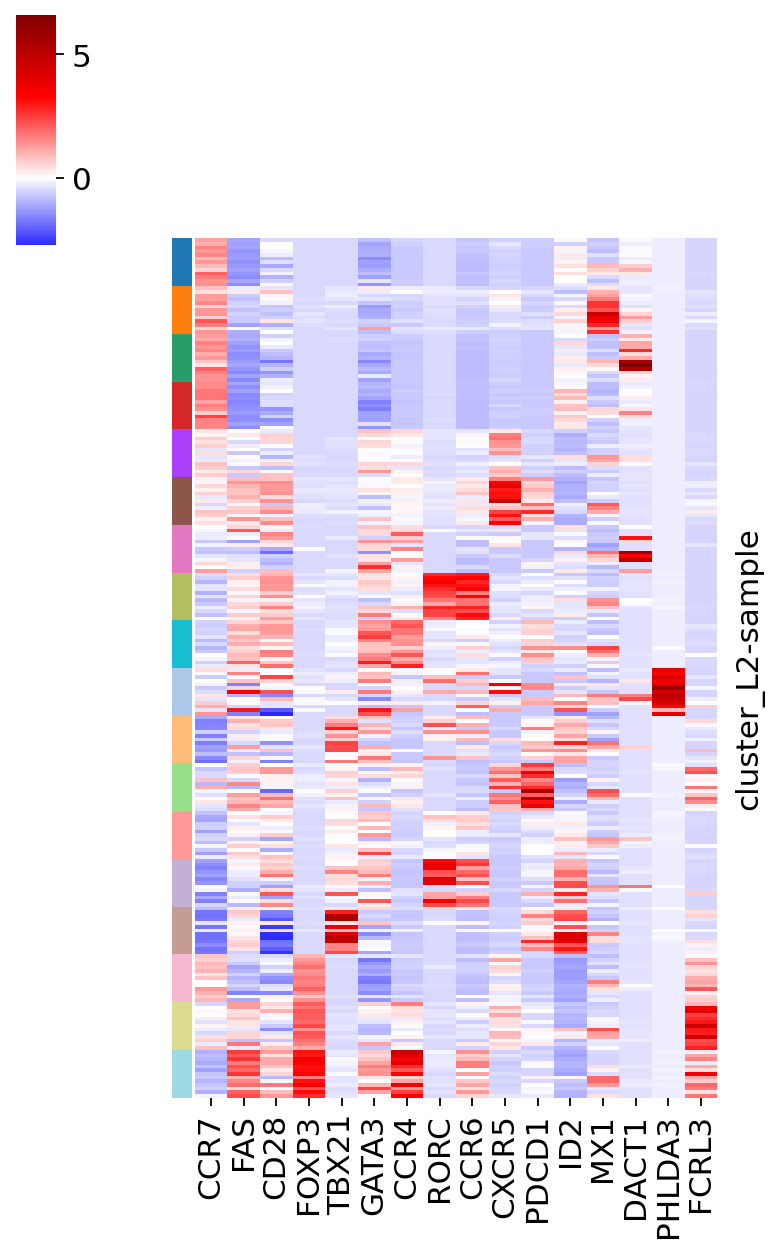

In [48]:
df_plot=pd.concat([df_markers, adata.obs[['sample', 'cluster_L2']]], axis=1).groupby(by=['cluster_L2', 'sample']).mean()
sns.clustermap(df_plot, 
               row_cluster=False, col_cluster=False, figsize=(5,8),
              yticklabels=False, xticklabels=True,
               row_colors=[adata.uns['cluster_L2_colors'][list(adata.obs['cluster_L2'].cat.categories).index(x[0])] for x in df_plot.index],
              z_score=1, center=0, cmap='seismic')

plt.savefig(f'{sc.settings.figdir}/heatmap_clusterL2_sample_markergene.pdf', bbox_inches='tight')

### TCR overlap validation

In [116]:
df_clones = adata.obs.loc[adata.obs['clone_id_size'] >= 2, ['clone_id', 'clone_id_size', 'sample', 'cluster_L1', 'cluster_L2']]
df_clones = df_clones.sort_values(by='clone_id_size', ascending=False)
df_clones.head()

,clone_id,clone_id_size,sample,cluster_L1,cluster_L2
index,,,,,
CACTCCAGTGACTACT-1-10,71286,253,SL02,Temra,Temra (Th1)
CCACCTATCTAGCACA-1-10,71286,253,SL02,Temra,Temra (Th1)
GTCCTCATCTCCTATA-1-10,71286,253,SL02,Temra,Temra (Th1)
ATCGAGTCAGTTCCCT-1-10,71286,253,SL02,Temra,Temra (Th1)
CCATGTCCAGATAATG-1-10,71286,253,SL02,Tem,Tem (Th1)


In [117]:
df_clones_nunique = df_clones.groupby(by='clone_id')[['sample', 'cluster_L1', 'cluster_L2']].nunique()
df_clones_nunique.columns = ['sample_nunique', 'cluster_L1_nunique', 'cluster_L2_nunique']
df_clones_nunique = df_clones_nunique[df_clones_nunique['cluster_L2_nunique'] > 0]
df_clones_nunique.head()

,sample_nunique,cluster_L1_nunique,cluster_L2_nunique
clone_id,,,
33,1,1,2
40,1,1,1
41,1,2,2
106,1,1,1
180,1,1,1


In [118]:
df_clones = pd.merge(df_clones, df_clones_nunique, left_on='clone_id', right_index=True)
df_clones = df_clones.drop_duplicates()
df_clones.head()

,clone_id,clone_id_size,sample,cluster_L1,cluster_L2,sample_nunique,cluster_L1_nunique,cluster_L2_nunique
index,,,,,,,,
CACTCCAGTGACTACT-1-10,71286,253,SL02,Temra,Temra (Th1),1,2,3
CCATGTCCAGATAATG-1-10,71286,253,SL02,Tem,Tem (Th1),1,2,3
GTATCTTAGCTAACAA-1-10,71286,253,SL02,Tem,Tem (Th1) pre,1,2,3
ACTTACTGTTTGTTGG-1-11,76660,240,SL03,Temra,Temra (Th1),1,2,3
ACTGATGTCATCTGCC-1-11,76660,240,SL03,Tem,Tem (Th1),1,2,3


In [119]:
df_clones.sort_values(by='cluster_L1_nunique', ascending=False).head(20)

,clone_id,clone_id_size,sample,cluster_L1,cluster_L2,sample_nunique,cluster_L1_nunique,cluster_L2_nunique
index,,,,,,,,
TTCTACAGTCATATGC-1-5,34293,7,MS03,Temra,Temra (Th1),1,4,4
CCAGCGATCATTATCC-1-5,34293,7,MS03,Tem,Tem (Th1) pre,1,4,4
CGTCCATGTTGGTAAA-1-5,34293,7,MS03,Tcm,Tcm (Th2),1,4,4
CCCATACTCACCATAG-1-5,34293,7,MS03,Tnaive,Tnaive,1,4,4
CGATCGGTCGGATGGA-1-7,49884,4,MG01,Tcm,Tcm (Th0),1,3,3
ACTGATGGTAGATTAG-1-7,46500,4,MG01,Tcm,Tcm (Th17),1,3,3
CTACATTGTGTGAATA-1-10,71521,45,SL02,Tem,Tem (Th1) pre,1,3,5
TGACTAGCAGGACGTA-1-10,71521,45,SL02,Tem,Tem (Tph),1,3,5
TGACTTTTCCCTAACC-1-10,71521,45,SL02,Tcm,Tcm PHLDA3,1,3,5


In [92]:
from cycler import cycler
from matplotlib import cm as mpl_cm

/home/yyasumizu/anaconda3/envs/scanpy1.9.1/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


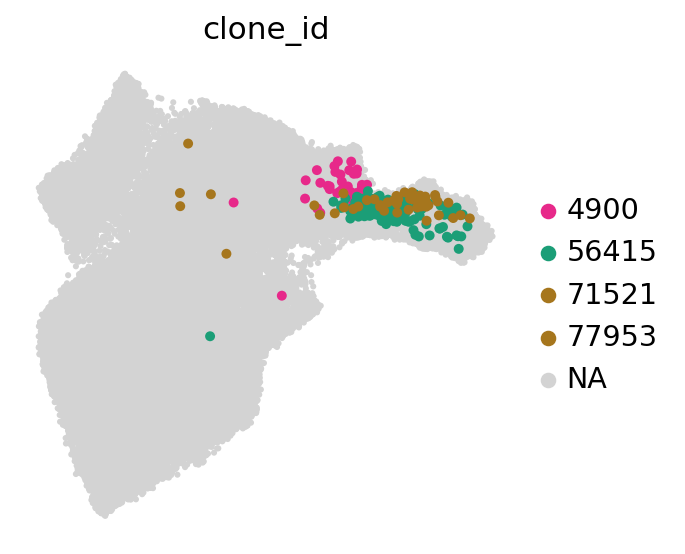

In [93]:
list_clones = ['56415', '71521', '4900', '77953']

sc.pl.umap(
    adata,
    color="clone_id",
    groups=list_clones,
    # increase size of highlighted dots
    size=[
        80 if c in list_clones else 30
        for c in adata.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

- naive -> cm
- cm -> em
- em -> emra

In [129]:
d = df_clones[df_clones.cluster_L1.isin(['Tnaive', 'Tcm'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 2]
df_clones['Tnaive_Tcm'] = df_clones.clone_id.isin(list(d.index))

d = df_clones[df_clones.cluster_L1.isin(['Tcm', 'Tem'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 2]
df_clones['Tcm_Tem'] = df_clones.clone_id.isin(list(d.index))

d = df_clones[df_clones.cluster_L1.isin(['Tem', 'Temra'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 2]
df_clones['Tem_Temra'] = df_clones.clone_id.isin(list(d.index))

In [194]:
d = df_clones[df_clones.cluster_L1.isin(['Tnaive'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 1]
df_clones['Tnaive'] = df_clones.clone_id.isin(list(d.index))

d = df_clones[df_clones.cluster_L1.isin(['Tcm'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 1]
df_clones['Tcm'] = df_clones.clone_id.isin(list(d.index))

d = df_clones[df_clones.cluster_L1.isin(['Tem'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 1]
df_clones['Tem'] = df_clones.clone_id.isin(list(d.index))

d = df_clones[df_clones.cluster_L1.isin(['Temra'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 1]
df_clones['Temra'] = df_clones.clone_id.isin(list(d.index))

d = df_clones[df_clones.cluster_L1.isin(['Treg'])].groupby(by='clone_id')[['cluster_L1']].nunique()
d = d[d['cluster_L1'] == 1]
df_clones['Treg'] = df_clones.clone_id.isin(list(d.index))

In [139]:
df_clones[df_clones['Tnaive_Tcm']]

,clone_id,clone_id_size,sample,cluster_L1,cluster_L2,sample_nunique,cluster_L1_nunique,cluster_L2_nunique,Tnaive_Tcm,Tcm_Tem,Tem_Temra,Tnaive,Tcm,Tem,Temra
index,,,,,,,,,,,,,,,
GATGCTATCTGGTGTA-1-7,45679,10,MG01,Tnaive,Tnaive,1,2,3,True,False,False,True,True,False,False
AAAGCAAAGAAAGTGG-1-7,45679,10,MG01,Tcm,Tcm (Th0),1,2,3,True,False,False,True,True,False,False
CAGAATCTCTCCTATA-1-7,45679,10,MG01,Tnaive,Tnaive Act,1,2,3,True,False,False,True,True,False,False
TTAACTCAGGGATGGG-1-7,46622,9,MG01,Tnaive,Tnaive,1,2,3,True,False,False,True,True,False,False
TGTTCCGAGCTAACTC-1-7,46622,9,MG01,Tnaive,Tnaive Act,1,2,3,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGATGACACGGCCAT-1-7,53137,2,MG01,Tnaive,Tnaive,1,2,2,True,False,False,True,True,False,False
GCTGGGTCATTTCAGG-1-7,52183,2,MG01,Tcm,Tcm (Th0),1,2,2,True,False,False,True,True,False,False
GCACATATCGTCGTTC-1-7,52183,2,MG01,Tnaive,Tnaive,1,2,2,True,False,False,True,True,False,False


/home/yyasumizu/anaconda3/envs/scanpy1.9.1/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


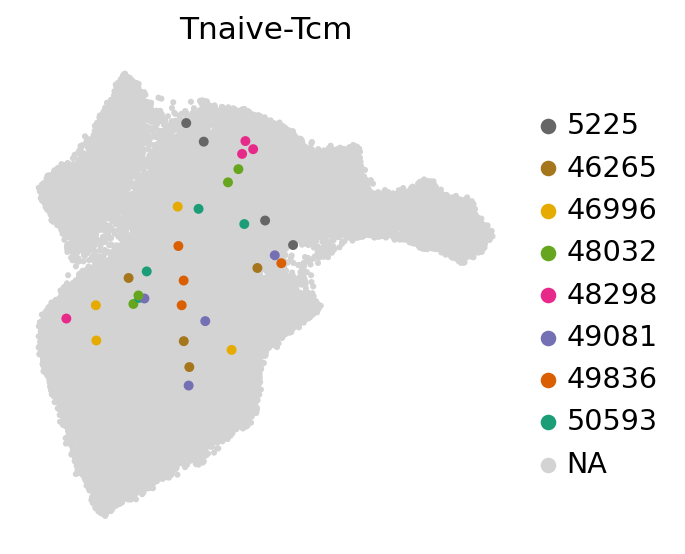

In [180]:
list_clones = list(df_clones.loc[(df_clones['Tnaive'])&(df_clones['Tcm'])&(~df_clones['Temra']), 'clone_id'].drop_duplicates())[10:18]
adata.obs['tmp_clone'] = [x if x in list_clones else np.nan for x in adata.obs['clone_id']]
sc.pl.umap(
    adata,
    color="tmp_clone",
    # groups=list_clones,
    # increase size of highlighted dots
    size=[
        80 if c in list_clones else 30
        for c in adata.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    # palette='viridis',
    title='Tnaive-Tcm',
    save='Tnaive_Tcm_notTemra'
)

/home/yyasumizu/anaconda3/envs/scanpy1.9.1/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


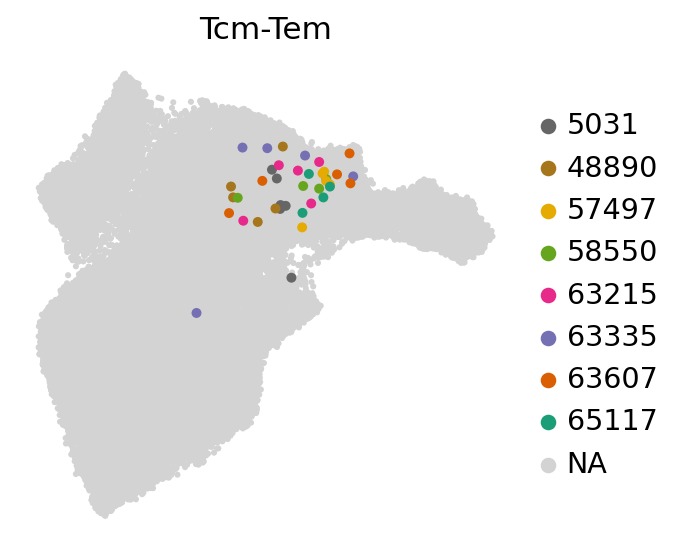

In [181]:
list_clones = list(df_clones.loc[(df_clones['Tcm'])&(df_clones['Tem'])&(~df_clones['Temra']), 'clone_id'].drop_duplicates())[12:20]
adata.obs['tmp_clone'] = [x if x in list_clones else np.nan for x in adata.obs['clone_id']]
sc.pl.umap(
    adata,
    color="tmp_clone",
    # groups=list_clones,
    # increase size of highlighted dots
    size=[
        80 if c in list_clones else 30
        for c in adata.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    # palette='viridis',
    title='Tcm-Tem',
    save='Tcm_Tem_notTemra'
)

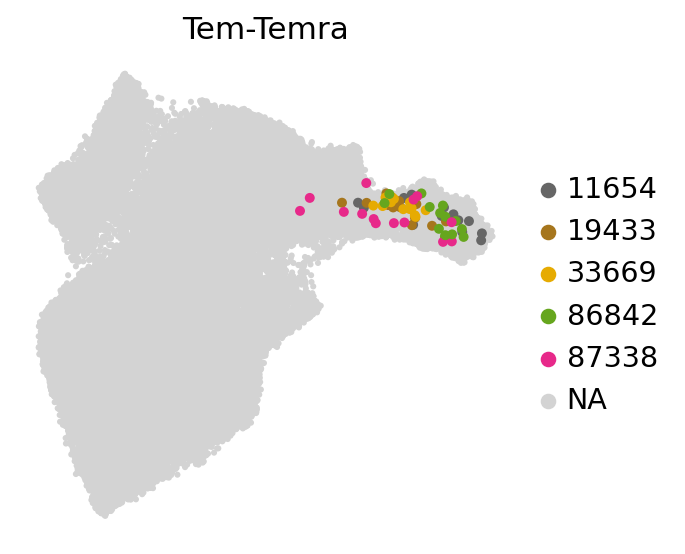

In [198]:
list_clones = list(df_clones.loc[(df_clones['Tem'])&(df_clones['Temra']), 'clone_id'].drop_duplicates())[40:45]
adata.obs['tmp_clone'] = [x if x in list_clones else np.nan for x in adata.obs['clone_id']]
sc.pl.umap(
    adata,
    color="tmp_clone",
    # groups=list_clones,
    # increase size of highlighted dots
    size=[
        80 if c in list_clones else 30
        for c in adata.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    # palette='viridis',
    title='Tem-Temra',
    save='Tem_Temra'
)

In [199]:
df_clones.loc[(df_clones['Tcm'])&(df_clones['Treg'])]

,clone_id,clone_id_size,sample,cluster_L1,cluster_L2,sample_nunique,cluster_L1_nunique,cluster_L2_nunique,Tnaive_Tcm,Tcm_Tem,Tem_Temra,Tnaive,Tcm,Tem,Temra,Treg
index,,,,,,,,,,,,,,,,
AGGTCATGTTACGTCA-1-10,72182,4,SL02,Tcm,Tcm (Tfh),1,3,3,True,False,False,True,True,False,False,True
CCGGTAGAGAAACGAG-1-10,72182,4,SL02,Tnaive,Tnaive MX1,1,3,3,True,False,False,True,True,False,False,True
TATTACCTCTCTTGAT-1-10,72182,4,SL02,Treg,Treg Act,1,3,3,True,False,False,True,True,False,False,True
ACTGCTCAGTATTGGA-1-10,71873,3,SL02,Treg,Treg Act,1,2,2,False,False,False,False,True,False,False,True
GACACGCGTTAAGGGC-1-10,71873,3,SL02,Tcm,Tcm (Th0),1,2,2,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGGCCACTCAACGAAA-1-3,20418,2,MS01,Treg,Treg Eff,1,2,2,False,False,False,False,True,False,False,True
CACATAGGTCTCCCTA-1-7,48462,2,MG01,Treg,Treg Naive,1,2,2,False,False,False,False,True,False,False,True
TAAGAGAGTCATATCG-1-7,48462,2,MG01,Tcm,Tcm (Th0),1,2,2,False,False,False,False,True,False,False,True


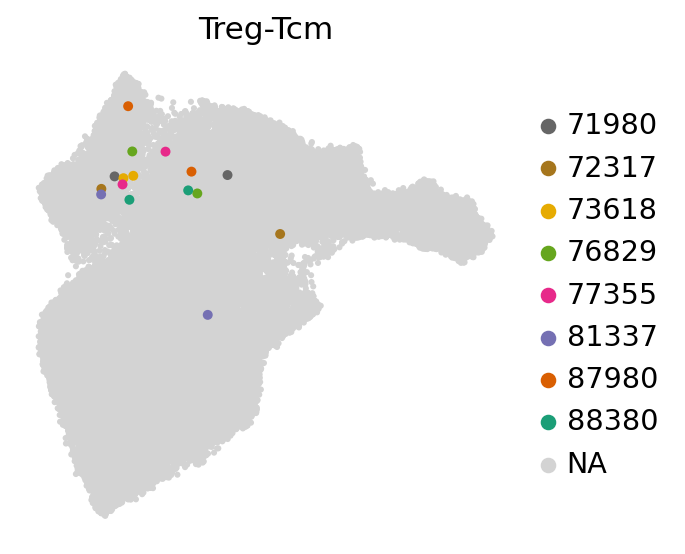

In [210]:
list_clones = list(df_clones.loc[(df_clones['Tcm'])&(df_clones['Treg']), 'clone_id'].drop_duplicates())[10:18]
adata.obs['tmp_clone'] = [x if x in list_clones else np.nan for x in adata.obs['clone_id']]
sc.pl.umap(
    adata,
    color="tmp_clone",
    # groups=list_clones,
    # increase size of highlighted dots
    size=[
        80 if c in list_clones else 30
        for c in adata.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    # palette='viridis',
    title='Treg-Tcm',
    save='Treg_Tcm'
)

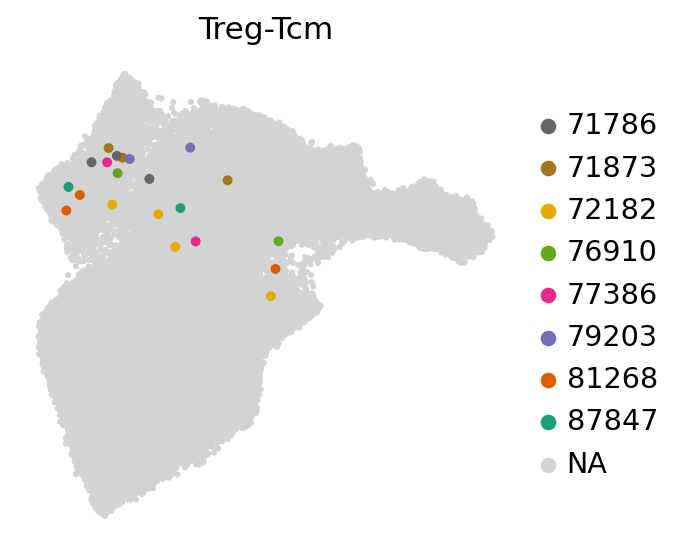

In [197]:
list_clones = list(df_clones.loc[(df_clones['Tcm'])&(df_clones['Treg']), 'clone_id'].drop_duplicates())[:8]
adata.obs['tmp_clone'] = [x if x in list_clones else np.nan for x in adata.obs['clone_id']]
sc.pl.umap(
    adata,
    color="tmp_clone",
    # groups=list_clones,
    # increase size of highlighted dots
    size=[
        80 if c in list_clones else 30
        for c in adata.obs["clone_id"]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
    # palette='viridis',
    title='Treg-Tcm',
    save='Treg_Tcm'
)

In [186]:
list_clones

[]

In [170]:
adata.obs['clone_id'].value_counts().sort_values()

79028      1
1131       1
1132       1
1133       1
1134       1
        ... 
56415    167
33527    202
19390    228
76660    240
71286    253
Name: clone_id, Length: 95246, dtype: int64

In [156]:
df_clones.loc[(df_clones['Tcm'])&(df_clones['Tem'])&(~df_clones['Temra'])]

,clone_id,clone_id_size,sample,cluster_L1,cluster_L2,sample_nunique,cluster_L1_nunique,cluster_L2_nunique,Tnaive_Tcm,Tcm_Tem,Tem_Temra,Tnaive,Tcm,Tem,Temra
index,,,,,,,,,,,,,,,
TTAGTTCCAATAGAGT-1-5,33441,19,MS03,Tem,Tem (Th1/17),1,2,2,False,True,False,False,True,True,False
AAAGATGAGTCGTTTG-1-5,33441,19,MS03,Tcm,Tcm (Th17),1,2,2,False,True,False,False,True,True,False
GTAGTCAAGACAAGCC-1-9,64020,10,MG03,Tem,Tem (Th1/17),1,2,3,False,True,False,False,True,True,False
TCTATTGAGCGAGAAA-1-9,64020,10,MG03,Tcm,Tcm (Th17),1,2,3,False,True,False,False,True,True,False
ATTGGACGTCAGATAA-1-9,64020,10,MG03,Tcm,Tcm PHLDA3,1,2,3,False,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTGAAGCATACTCTT-1-7,53274,2,MG01,Tcm,Tcm (Th17),1,2,2,False,True,False,False,True,True,False
TGACGGCTCTCTGAGA-1-7,51804,2,MG01,Tem,Tem (Th1/17),1,2,2,False,True,False,False,True,True,False
GACTACACACCCATGG-1-7,51804,2,MG01,Tcm,Tcm (Th17),1,2,2,False,True,False,False,True,True,False
